# PREDICTIVE MODELLING OF DIABETES MELLITUS USING MACHINE LEARNING TECHNIQUES

IMPORT REQUIRED LIBRARIES FOR DATA HANDLING, VISUALIZATION, AND MACHINE LEARNING

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, matthews_corrcoef

#  Load the diabetes dataset from Google Drive
file_id = "12BohocyLF92kjBklG8rgY-toKWcN7BJu"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
df = pd.read_csv(url)




# **EDA**

In [23]:
# Drop irrelevant columns (ID and patient number), not useful for model learning
df.drop(columns=["ID", "No_Pation"], inplace=True)

#  Clean and standardize the 'CLASS' column
# Convert class labels to uppercase and strip any extra whitespace to avoid inconsistencies
df["CLASS"] = df["CLASS"].str.upper().str.strip()

# Remove any duplicate rows to avoid data redundancy and biased learning
df = df.drop_duplicates()


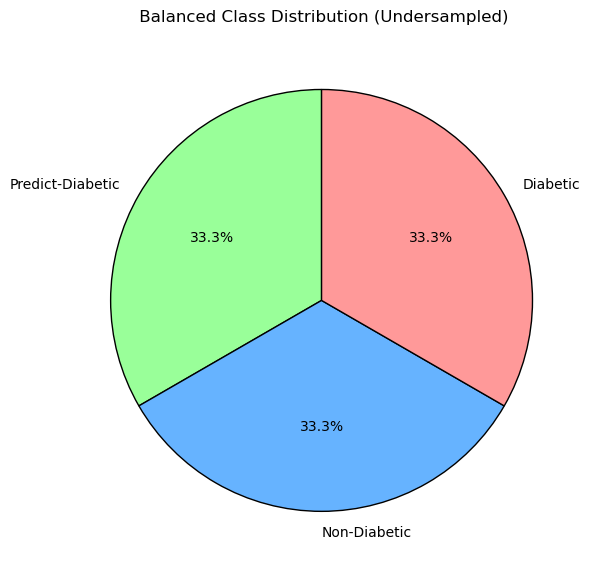

In [24]:

#  Class Balancing using Undersampling

# To prevent overfitting and high variance, we undersample each class to match the size of the smallest class

class_dfs = {cls: df[df["CLASS"] == cls] for cls in df["CLASS"].unique()}
min_size = min(len(group) for group in class_dfs.values())
undersampled_classes = [group.sample(n=min_size, random_state=42) for group in class_dfs.values()]
df_balanced = pd.concat(undersampled_classes).sample(frac=1, random_state=42).reset_index(drop=True)

# Visualize the class distribution using a pie chart

# This ensures that all classes are equally represented (balanced) after undersampling

label_map = {"N": "Non-Diabetic", "P": "Predict-Diabetic", "Y": "Diabetic"}
class_counts = df_balanced["CLASS"].value_counts()
class_labels = class_counts.index.map(label_map)

plt.figure(figsize=(6, 6))
plt.pie(
    class_counts,
    labels=class_labels,
    autopct='%1.1f%%',
    colors=["#99ff99", "#66b3ff", "#ff9999"],
    startangle=90,
    wedgeprops={'linewidth': 1, 'edgecolor': 'black'}
)
plt.title(" Balanced Class Distribution (Undersampled)")
plt.axis("equal")  # Equal aspect ratio ensures the pie is a circle
plt.tight_layout()
plt.show()



In [25]:
#  Encoding categorical columns for ML algorithms (which only work with numeric inputs)

# Encoding 'Gender': M → 1, F → 0

df_balanced["Gender"] = LabelEncoder().fit_transform(df_balanced["Gender"])

# Explicitly encoding class labels: N → 0, P → 1, Y → 2

class_mapping = {"N": 0, "P": 1, "Y": 2}
df_balanced["CLASS"] = df_balanced["CLASS"].map(class_mapping)


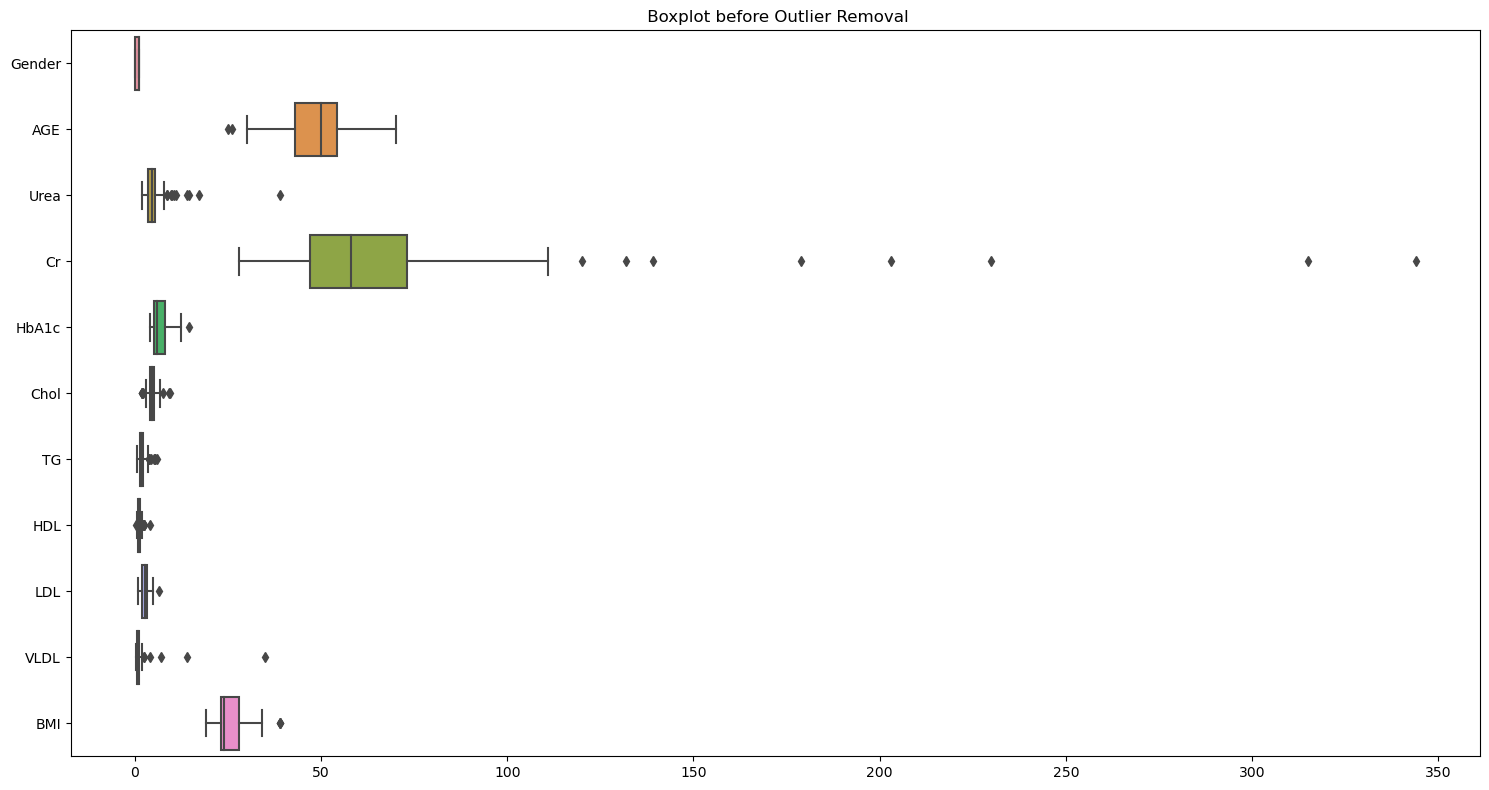

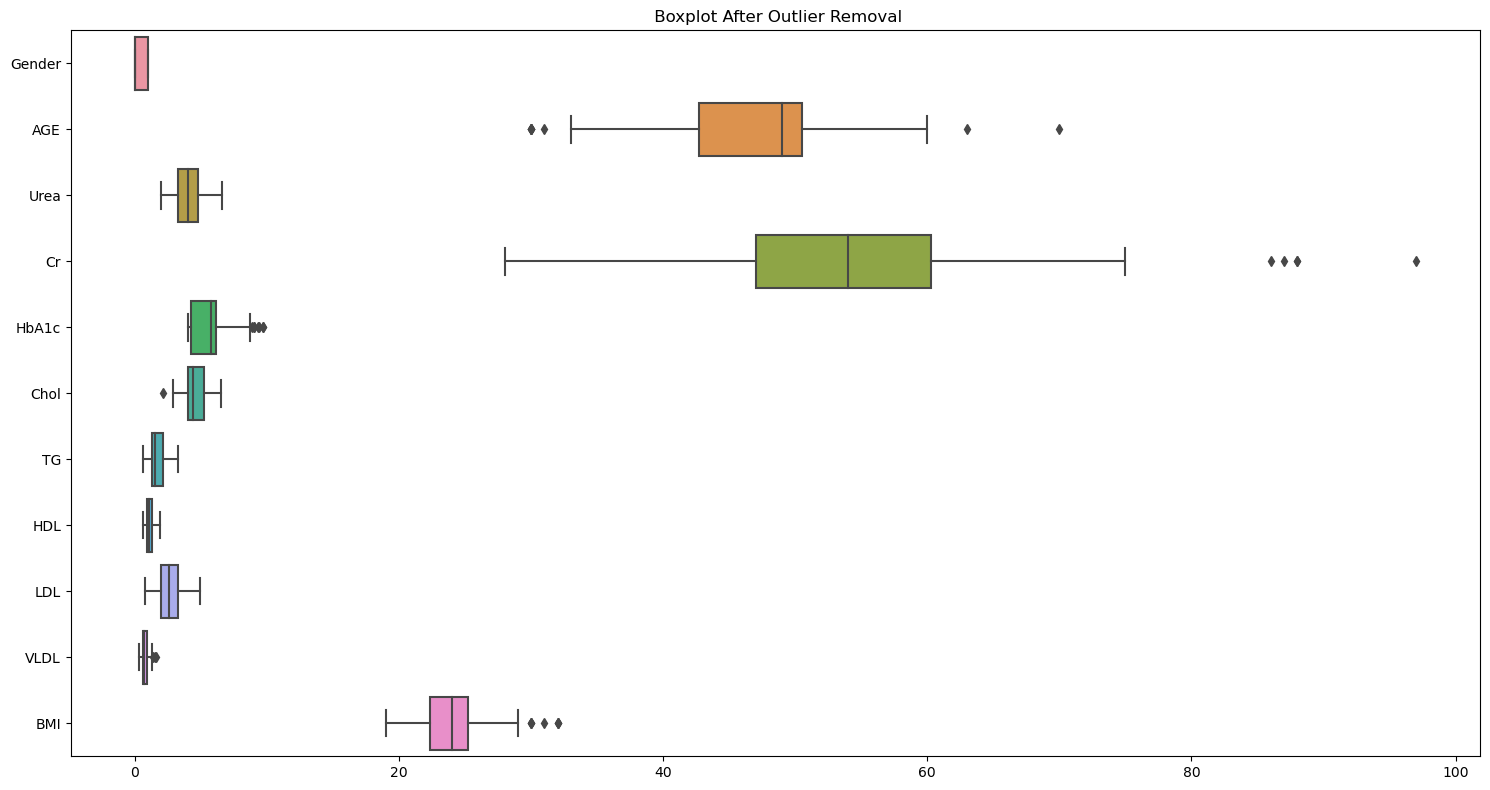

In [26]:

# Outlier Detection and Removal using the Interquartile Range (IQR) method

# Removes extreme values in numeric columns (excluding 'CLASS') to improve model generalization

def remove_outliers_iqr(data):
    cleaned_data = data.copy()
    for col in cleaned_data.select_dtypes(include=[np.number]).columns:
        if col == "CLASS":
            continue  # Don't apply outlier removal on the target class
        Q1 = cleaned_data[col].quantile(0.25)
        Q3 = cleaned_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        cleaned_data = cleaned_data[(cleaned_data[col] >= lower_bound) & (cleaned_data[col] <= upper_bound)]
    return cleaned_data

plt.figure(figsize=(15, 8))
sns.boxplot(data=df_balanced.drop(columns="CLASS"), orient='h')
plt.title(" Boxplot before Outlier Removal")
plt.tight_layout()
plt.show()


df_balanced = remove_outliers_iqr(df_balanced)

# Visualize numeric feature distributions after outlier removal using a boxplot

plt.figure(figsize=(15, 8))
sns.boxplot(data=df_balanced.drop(columns="CLASS"), orient='h')
plt.title(" Boxplot After Outlier Removal")
plt.tight_layout()
plt.show()



# Correlation Heatmap

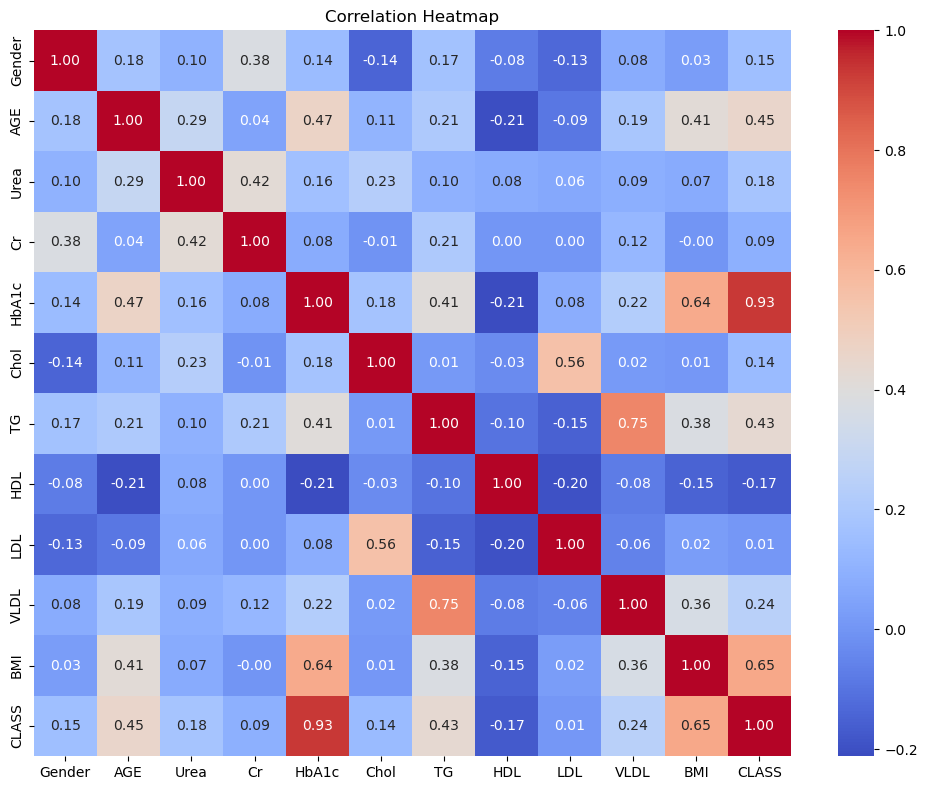

In [27]:
# Helps identify relationships between features (e.g., multicollinearity)

plt.figure(figsize=(10, 8))
sns.heatmap(df_balanced.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


# **DATA SPLITING**

In [28]:

#  Split dataset into training and testing sets

# Stratified split ensures class distribution is preserved in both sets

X = df_balanced.drop("CLASS", axis=1)
y = df_balanced["CLASS"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#  Feature Scaling using StandardScaler

# Ensures all features contribute equally to the model by converting them to the same scale

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# **INTIALIZING AND TRAINING THE MODELS**

In [29]:

# Random Forest: Ensemble of decision trees

# MLP (Multi-Layer Perceptron): Basic feedforward neural network

rf = RandomForestClassifier(random_state=41)
mlp = MLPClassifier(max_iter=1000, random_state=42)

#  K-Fold Cross-Validation

# Splits training data into 5 folds to evaluate performance across different subsets

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_cv = cross_val_score(rf, X_train_scaled, y_train, cv=kf, scoring='accuracy')
mlp_cv = cross_val_score(mlp, X_train_scaled, y_train, cv=kf, scoring='accuracy')

print(f"\n Random Forest CV Accuracy: {rf_cv.mean():.4f}")
print(f" MLP Neural Network CV Accuracy: {mlp_cv.mean():.4f}")



 Random Forest CV Accuracy: 0.9833
 MLP Neural Network CV Accuracy: 0.8788



 Evaluation for Random Forest
 Accuracy: 0.9333333333333333
 Matthews Corr. Coefficient: 0.9041944301794651
 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.83      0.91         6
           2       0.75      1.00      0.86         3

    accuracy                           0.93        15
   macro avg       0.92      0.94      0.92        15
weighted avg       0.95      0.93      0.94        15



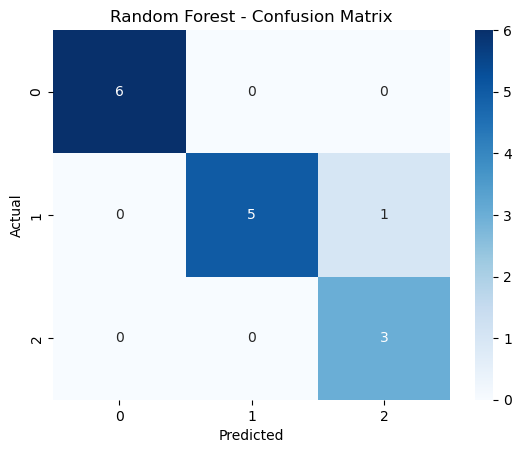


 Evaluation for MLP Neural Network
 Accuracy: 0.6666666666666666
 Matthews Corr. Coefficient: 0.5197011503876874
 Classification Report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       0.67      0.33      0.44         6
           2       1.00      0.67      0.80         3

    accuracy                           0.67        15
   macro avg       0.76      0.67      0.66        15
weighted avg       0.71      0.67      0.64        15



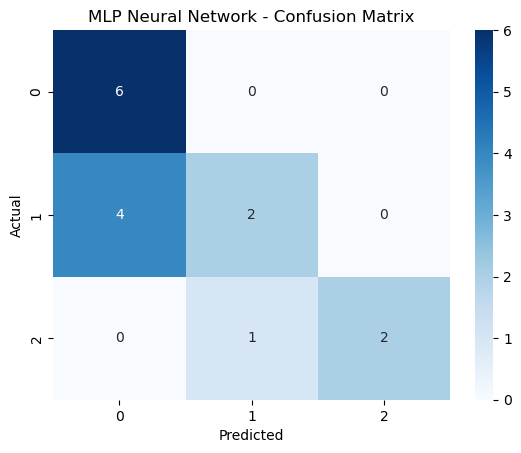

In [30]:

#  Train both models on the full training set

rf.fit(X_train_scaled, y_train)
mlp.fit(X_train_scaled, y_train)

#  Predict class labels on the test set

rf_pred = rf.predict(X_test_scaled)
mlp_pred = mlp.predict(X_test_scaled)

#  Evaluation Function: Accuracy, MCC, Confusion Matrix & Classification Report

def evaluate_model(name, y_true, y_pred):
    print(f"\n Evaluation for {name}")
    print(" Accuracy:", accuracy_score(y_true, y_pred))
    print(" Matthews Corr. Coefficient:", matthews_corrcoef(y_true, y_pred))
    print(" Classification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

#  Evaluate both models

evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("MLP Neural Network", y_test, mlp_pred)


 Evaluation for Hybrid RF + MLP (Voting)
 Accuracy: 0.8666666666666667
 Matthews Corr. Coefficient: 0.8125
 Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.67      0.80         6
           2       0.75      1.00      0.86         3

    accuracy                           0.87        15
   macro avg       0.87      0.89      0.86        15
weighted avg       0.89      0.87      0.86        15



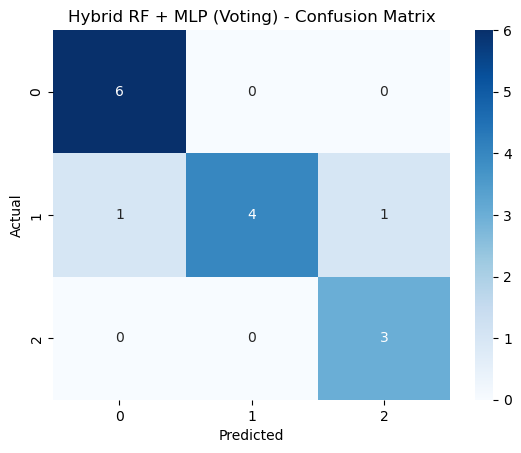

In [31]:
from sklearn.ensemble import VotingClassifier

hybrid_model = VotingClassifier(estimators=[
    ('rf', rf), 
    ('mlp', mlp)
], voting='soft')  # Use 'soft' if you want to average predicted probabilities

hybrid_model.fit(X_train_scaled, y_train)
hybrid_pred = hybrid_model.predict(X_test_scaled)

evaluate_model("Hybrid RF + MLP (Voting)", y_test, hybrid_pred)


Machine learning models proved effective for the early detection of diabetes mellitus.

Random Forest:

    Showed excellent predictive power.

    Handled high-dimensional data and complex variable interactions.

    Achieved a high MCC, indicating balanced performance despite class imbalance.

    Provided feature importance insights, aiding clinical interpretability.

MLP Neural Network:

    Capable of learning non-linear patterns, but less consistent.

    Performance was sensitive to data scaling and hyperparameter tuning.

    Best suited for larger or more complex datasets.

Hybrid RF + MLP Model (Voting Classifier):

    Combined strengths of both models using soft voting.

    Achieved a balanced trade-off between accuracy (86.6%) and generalizability.

    Maintained a high MCC (0.81), ensuring stable predictions across all classes.

    Demonstrated the value of ensemble methods for clinical deployment.

Key predictive features identified by Random Forest: glucose levels, BMI, age, and number of pregnancies — all clinically relevant.

Cross-validation was used across all models to enhance reliability and prevent overfitting.